In [1]:
#tahap identifikasi data, sampai dengan uji ADF apakah perlu differencing atau tidak, jika tidak perlu, gunakan syntax sarima2

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
data = pd.read_csv('Data.csv')
print(data.tail())





    NO  data01
32  33      49
33  34     101
34  35     151
35  36     204
36  37      51


In [2]:
#2 menganalisa stasioneritas data

from statsmodels.tsa.stattools import adfuller
adft = adfuller(data['data01'],autolag="AIC")
output_df = pd.DataFrame({"Values01":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)
print(1 * "\n")




    Values01                       Metric
0  -1.106268              Test Statistics
1   0.712566                      p-value
2   4.000000             No. of lags used
3  32.000000  Number of observations used
4  -3.653520          critical value (1%)
5  -2.957219          critical value (5%)
6  -2.617588         critical value (10%)




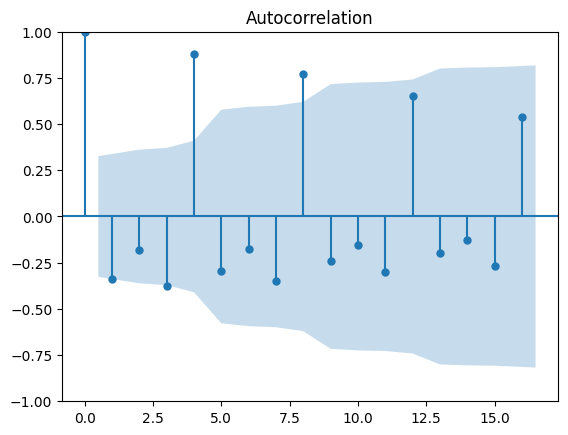

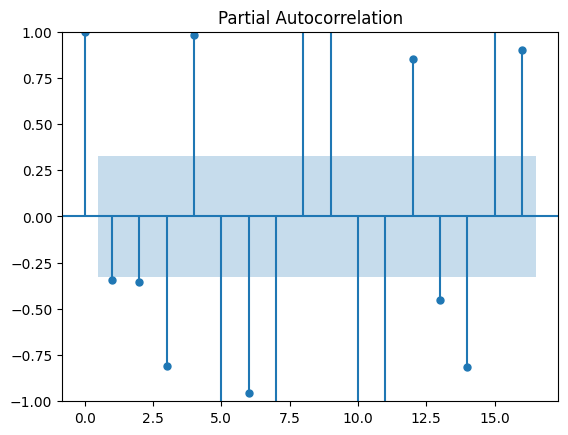

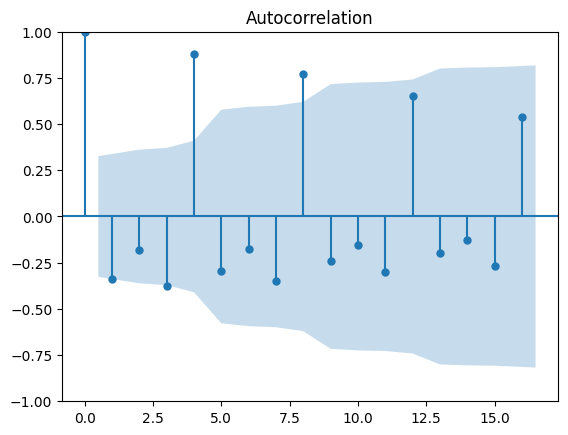

In [3]:
#tahap differencing dan pengecekan acf pacf untuk menentukan lag musiman

data['data01'] = np.log(data['data01'])
data['data01'] = data['data01'].diff()
data = data.drop(data.index[0])

plot_pacf(data['data01'])
plot_acf(data['data01'])

In [5]:
#setting sarima

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
#simulasi mencari model sarimax terbaik

p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 2, data['data01'])
result_df



16


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 0, 1, 1)",-20.931830
1,"(0, 1, 1, 0)",-20.322796
2,"(0, 1, 1, 1)",-19.872658
3,"(1, 1, 1, 0)",-18.695841
4,"(1, 1, 1, 1)",-18.058007
5,"(1, 0, 1, 0)",-11.962294
6,"(0, 0, 1, 0)",-0.993236
7,"(0, 0, 1, 1)",-0.398734
8,"(0, 1, 0, 1)",80.737389
9,"(1, 1, 0, 1)",82.664788


                                     SARIMAX Results                                     
Dep. Variable:                            data01   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  17.858
Date:                           Sat, 04 Feb 2023   AIC                            -29.717
Time:                                   00:18:58   BIC                            -25.415
Sample:                                        0   HQIC                           -28.314
                                            - 36                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6185      0.184     -3.355      0.001      -0.980      -0.257
ar.S.L4       -0.6291      0.140     -4.509

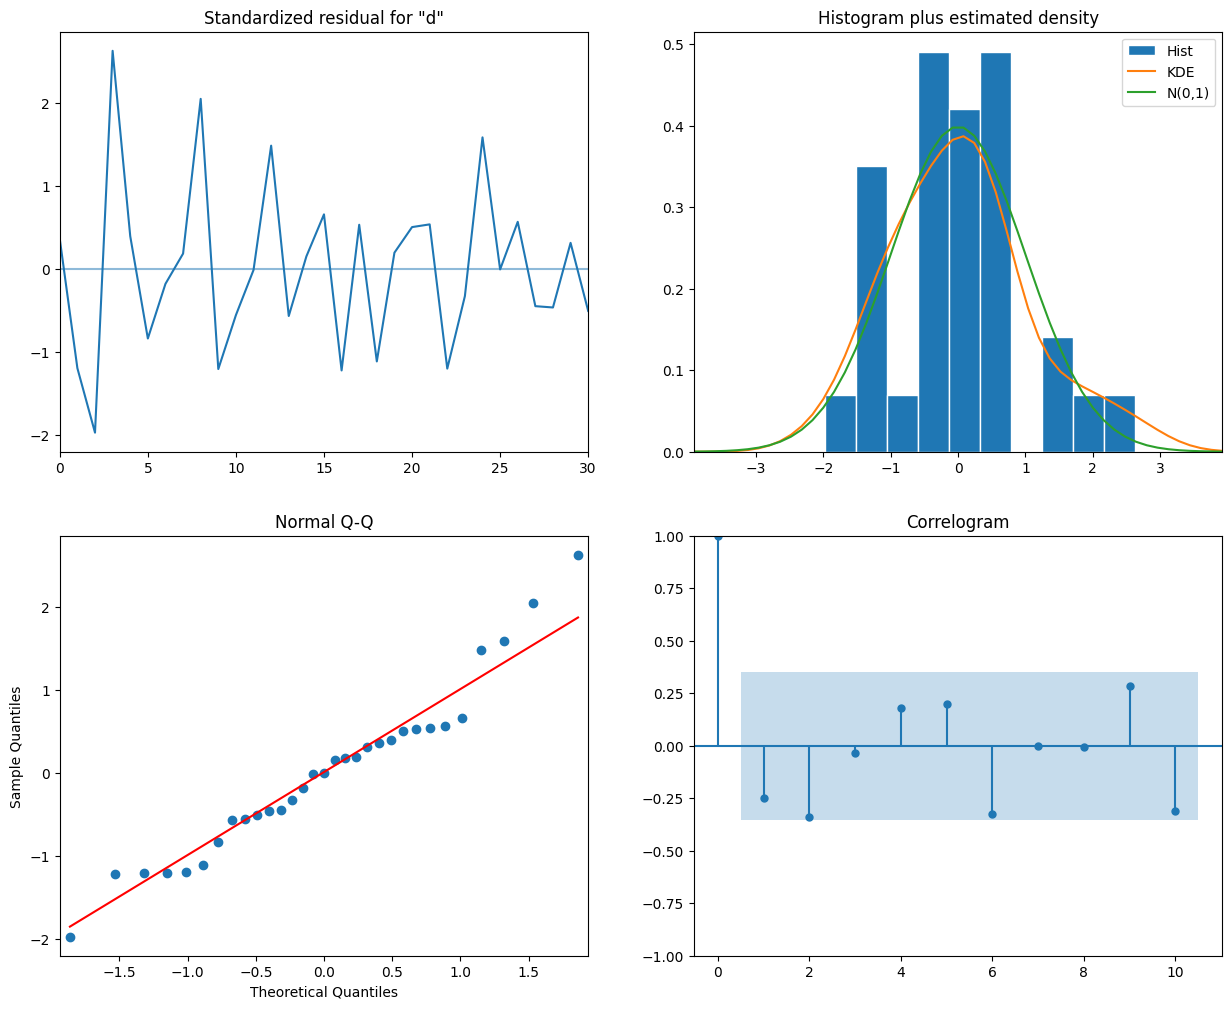

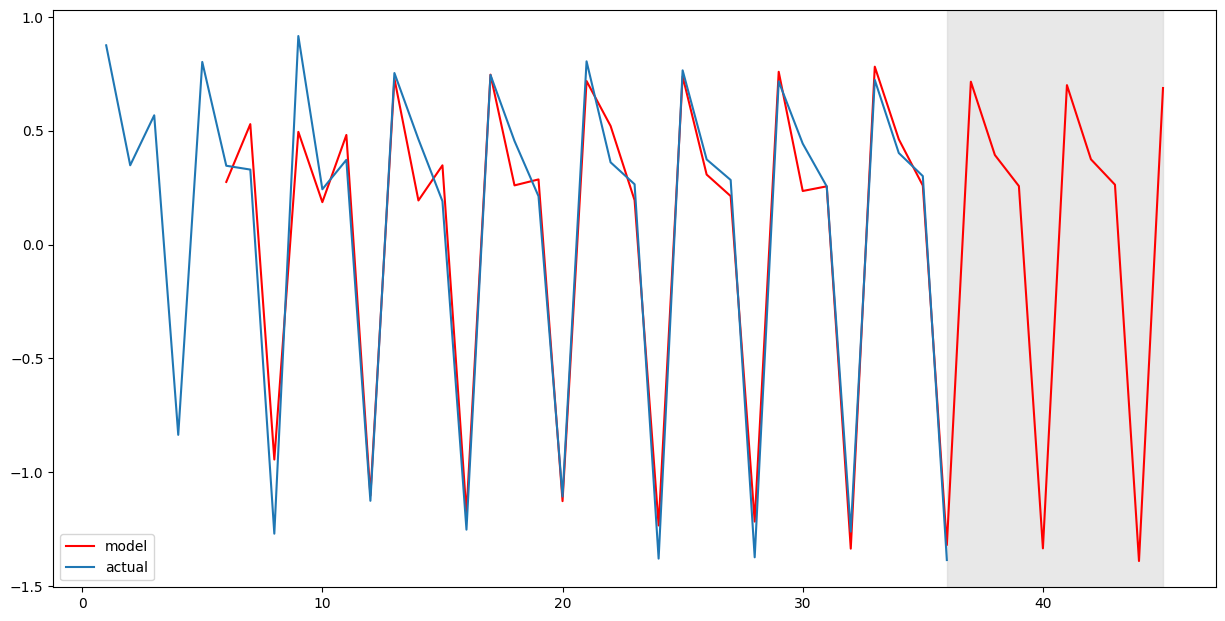

data01 sudah selesai


In [10]:
best_model = SARIMAX(data['data01'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 4)).fit(dis=-1)
print(best_model.summary())

best_model.plot_diagnostics(figsize=(15,12));
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data01'], label='actual')
#plt.plot(data['data'], label='actual')
plt.legend()
plt.show()


#save hasil kedalam excel untuk proses selanjutnya
forecast = pd.DataFrame(forecast)
# determining the name of the file
file_name = '01 differ_forecast.xlsx'
# saving the excel
forecast.to_excel(file_name)
data_differ = pd.DataFrame(data['data01'])
# determining the name of the file
file_name = '01 differ.xlsx'
# saving the excel
data_differ.to_excel(file_name)
print("data01 sudah selesai")
